# Homework 1. Likelihood-based models

- Seminar (5 points): Warmup
- Task 1 (10 points): PixelCNN
- **Task 2 (10 points): Conditional PixelCNN**
- Task 3 (10 points): RealNVP
- \* Bonus (10+++ points)

## Task 2. Conditional PixelCNNs on Shapes and MNIST

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise). You may need `nn.Embedding` here

You can use a PixelCNN architecture similar to Task 2. Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes

Feel free to use and modify any sources from Task 2

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

In [2]:
torch.manual_seed(43)

In [3]:
import pickle
from torchvision.utils import make_grid


def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [4]:
# For colab users: download data
#! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl
#! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

In [5]:
class MaskedConv2D(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
    
    def forward(self, x):
        """
        x: (N, C_in, H_in, W_in) torch.Tensor
        Returns
          - out (N, C_out, H_out, W_out) should be conv2d(x, weight * mask) + bias 
        """
        return self._conv_forward(x, self.weight * self.mask, self.bias)
    
    def create_mask(self, mask_type):
        assert mask_type == 'A' or mask_type == 'B'
        k = self.kernel_size[0]
        for i in range(k // 2):
            self.mask[:, :, i] = torch.ones(1, k)
        for i in range(k // 2):
            self.mask[:, :, k // 2, i] = 1
        self.mask[:, :, k // 2, k // 2] = 1 if mask_type == 'B' else 0
        

In [6]:
convA = MaskedConv2D('A', 1, 1, kernel_size=3)
convB = MaskedConv2D('B', 1, 1, kernel_size=3)
#print(convA.mask.view(-1), [1., 1., 1., 1., 0., 0., 0., 0., 0.])
#print(convB.mask.view(-1), [1., 1., 1., 1., 1., 0., 0., 0., 0.])
assert np.allclose(convA.mask.view(-1), [1., 1., 1., 1., 0., 0., 0., 0., 0.], atol=1e-6)
assert np.allclose(convB.mask.view(-1), [1., 1., 1., 1., 1., 0., 0., 0., 0.], atol=1e-6)

In [7]:
class ConditionalConv(nn.Module):
    def __init__(self, emb_dim=64, use_relu=True, use_bn=True, **conv_kwargs):
        super().__init__()

        self.conv = MaskedConv2D(**conv_kwargs)
        self.bn = nn.BatchNorm2d(conv_kwargs['out_channels']) if use_bn else None
        self.relu = nn.ReLU() if use_relu else None
        
        self.conditional_bias = nn.Linear(emb_dim, conv_kwargs['out_channels'])

    def forward(self, x, label_emb):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)

        cond_bias = self.conditional_bias(label_emb)[..., None, None]
        

        return x + cond_bias

In [8]:
class ConditionalPixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors=2, n_classes=4, emb_dim=64, n_filters=64,
               kernel_size=7, n_layers=5):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]
        
        self.input_shape = input_shape
        self.n_channels = n_channels
        self.n_colors = n_colors
        
        modules = []
        modules += [
            ConditionalConv(emb_dim=emb_dim, use_relu=True, use_bn=True, mask_type='A',
                             in_channels=n_channels, out_channels=n_filters,
                               kernel_size=kernel_size, padding=kernel_size // 2),
        ]

        for _ in range(n_layers):
            modules += [
                ConditionalConv(emb_dim=emb_dim, use_relu=True, use_bn=True, mask_type='B',
                             in_channels=n_filters, out_channels=n_filters,
                               kernel_size=kernel_size, padding=kernel_size // 2),
            ]
        

        modules += [
            ConditionalConv(emb_dim=emb_dim, use_relu=True, use_bn=True, mask_type='B',
                             in_channels=n_filters, out_channels=n_filters,
                               kernel_size=1, padding=0),
            ConditionalConv(emb_dim=emb_dim, use_relu=True, use_bn=True, mask_type='B',
                             in_channels=n_filters, out_channels=1,
                               kernel_size=1, padding=0),
        ]

        self.emb = nn.Embedding(n_classes, emb_dim)
        self.net = nn.ModuleList(modules)
        self.linear = nn.Linear(1, n_colors)
        
    def forward(self, x, cond):
        batch_size = x.shape[0]
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5

        cond = self.emb(cond)

        for layer in self.net:
            x = layer(x, cond)
        
        x = self.linear(x[..., None])
        return x.permute(0, 4, 1, 2, 3)

    def loss(self, x, cond):
        target = x.long()
        pred = self.forward(x, cond)
        
        return F.cross_entropy(pred, target)

    def sample(self, n, cond):
        samples = torch.zeros(n, *self.input_shape).cuda()
        cond = cond.cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self.forward(samples, cond)[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [9]:
from typing import Tuple, Any
from torchvision.transforms import ToTensor, Compose, Scale

class ShapesDataset(Dataset):
    def __init__(self, data, conditions, transforms=None):
        self.data = data
        assert len(conditions) == len(data)
        self.conditions = conditions
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        sample = torch.FloatTensor(self.data[index]).permute(2, 0, 1)

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample, torch.tensor(self.conditions[index])
    
    
class MinMaxScalerVectorized(object):
    """MinMax Scaler

    Transforms each channel to the range [a, b].

    Parameters
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, tensor):
        """Fit features

        Parameters
        ----------
        stacked_features : tuple, list
            List of stacked features.

        Returns
        -------
        tensor 
            A tensor with scaled features using requested preprocessor.
        """

        #tensor = torch.stack(tensor)

        # Feature range
        a, b = self.feature_range

        #print(tensor.max(dim=0, keepdim=True)[0])
        dist = tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0]
        dist[dist == 0.0] = 1.0
        scale = 1.0 / dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        tensor.mul_(b - a).add_(a)

        return tensor


In [10]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x, cond in train_loader:
        x, cond = x.cuda(), cond.cuda()
        loss = model.loss(x, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, cond in data_loader:
            x, cond = x.cuda(), cond.cuda()
            loss = model.loss(x, cond)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses
    

def train_model(train_data, train_labels, test_data, test_labels, num_classes, model, train_dataloader_kwargs, test_dataloader_kwargs, training_kwargs):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    train_labels: A (n_train, 1) int64 numpy array or image labels with values in {0, 1, ..., num_classes - 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_labels: A (n_test, 1) int64 numpy array or image labels with values in {0, 1, ..., num_classes - 1}
    num_classes: int
    model: nn.Model item
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    model.cuda()
    test_losses = []
    train_losses = []

    train_transforms = Compose([
        MinMaxScalerVectorized(feature_range=(-1, 1)),
    ])

    test_transforms = Compose([
        MinMaxScalerVectorized(feature_range=(-1, 1)),
    ])

    train_dataset = ShapesDataset(train_data, train_labels, transforms=None)
    test_dataset = ShapesDataset(test_data, test_labels, transforms=None)

    train_dataloader = DataLoader(train_dataset, **train_dataloader_kwargs)
    test_dataloader = DataLoader(test_dataset, **test_dataloader_kwargs)

    test_losses.append(eval_loss(model, test_dataloader))

    train_loss, test_loss = train_epochs(model, train_dataloader, test_dataloader, training_kwargs)
    test_losses += test_loss
    train_losses += train_loss

    return np.array(train_losses), np.array(test_losses), model
    


### First dataset: **Shapes** (5 points)

In [11]:
shapes_train, shapes_test, shapes_labels_train, shapes_labels_test = \
    load_data('./shapes.pkl', include_labels=True)

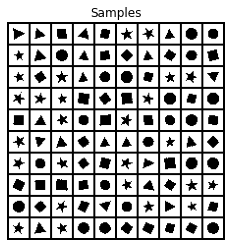

In [12]:
show_samples(shapes_train[:100])

In [13]:
num_classes = shapes_labels_train.max() + 1
num_classes

4

In [14]:
train_dataloader_config = {
    'batch_size': 128,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 128,
    'shuffle': False,
}

learning_config = {
    'lr': 1E-3,
    'epochs': 10,
}

H, W, _ = shapes_train[0].shape

In [15]:
model = ConditionalPixelCNN((1, H, W), n_classes=num_classes)
train_losses, test_losses, shapes_model = train_model(
    shapes_train, shapes_labels_train,
    shapes_test, shapes_labels_test,
    num_classes,
    model, train_dataloader_config, test_dataloader_config, learning_config)

epoch 0 started
train loss: 0.47488694510808804, test_loss: 0.2943659722805023
epoch 1 started
train loss: 0.35382565728774884, test_loss: 0.21662800014019012
epoch 2 started
train loss: 0.29710379660856434, test_loss: 0.16837343573570251
epoch 3 started
train loss: 0.2590089420356402, test_loss: 0.12873999774456024
epoch 4 started
train loss: 0.22917585936261387, test_loss: 0.10241656750440598
epoch 5 started
train loss: 0.20557839994326355, test_loss: 0.07768739014863968
epoch 6 started
train loss: 0.18655398992970845, test_loss: 0.06698747724294662
epoch 7 started
train loss: 0.171099843769675, test_loss: 0.05935380235314369
epoch 8 started
train loss: 0.15831271612002112, test_loss: 0.053974177688360214
epoch 9 started
train loss: 0.14759147589708246, test_loss: 0.049281466752290726


In [16]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()

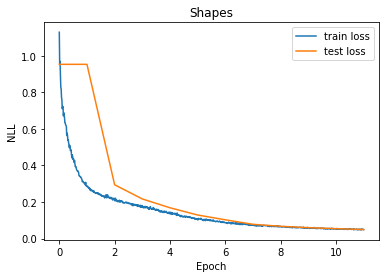

In [17]:
show_train_plots(train_losses, test_losses, 'Shapes')

In [18]:
labels = [0] * 25 + [1] * 25 + [2] * 25 + [3] * 25

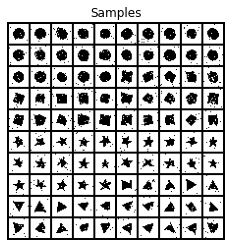

In [19]:
samples = shapes_model.sample(100, torch.tensor(labels, dtype=torch.long))
show_samples(samples)

### Second dataset: MNIST (5 points)

In [20]:
mnist_train, mnist_test, mnist_labels_train, mnist_labels_test = \
    load_data('./mnist.pkl', include_labels=True)

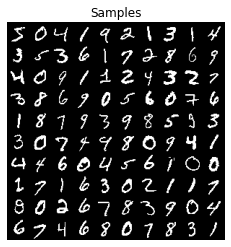

In [21]:
show_samples(mnist_train[:100])

In [22]:
num_classes = mnist_labels_train.max() + 1
num_classes

10

In [23]:
H, W, _ = mnist_train[0].shape
model = ConditionalPixelCNN((1, H, W), n_classes=num_classes)

In [24]:

train_losses, test_losses, mnist_model = train_model(
    mnist_train, mnist_labels_train,
    mnist_test, mnist_labels_test,
    num_classes,
    model, train_dataloader_config, test_dataloader_config, learning_config)

epoch 0 started
train loss: 0.3126471302847364, test_loss: 0.13572636246681213
epoch 1 started
train loss: 0.20768357985722485, test_loss: 0.08571864664554596
epoch 2 started
train loss: 0.0950676542893052, test_loss: 0.07766389101743698
epoch 3 started
train loss: 0.07883720458298922, test_loss: 0.07409466803073883
epoch 4 started
train loss: 0.07494800840318203, test_loss: 0.07311248034238815
epoch 5 started
train loss: 0.07324053017050028, test_loss: 0.07245969027280807
epoch 6 started
train loss: 0.07230993624031544, test_loss: 0.07222859561443329
epoch 7 started
train loss: 0.07166053377836942, test_loss: 0.07271560281515121
epoch 8 started
train loss: 0.07120292715728282, test_loss: 0.07143495231866837
epoch 9 started
train loss: 0.07089644345641136, test_loss: 0.07096970826387405


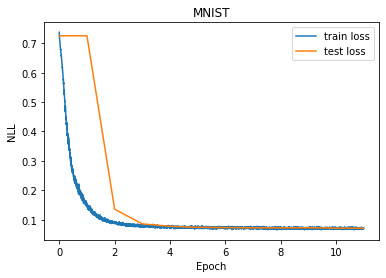

In [25]:
show_train_plots(train_losses, test_losses, 'MNIST')

In [26]:
labels = np.array(list(range(10)) * 10).T

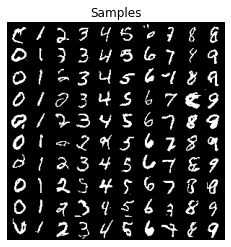

In [27]:
samples = mnist_model.sample(100, torch.tensor(labels, dtype=torch.long))
show_samples(samples)

In [28]:
labels = [1] * 100

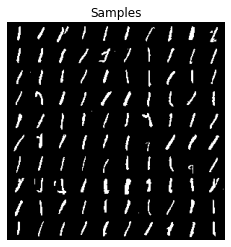

In [29]:
samples = mnist_model.sample(100, torch.tensor(labels, dtype=torch.long))
show_samples(samples)